In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

In [2]:
data_marix = np.load('extract/extact_matrix.npy', allow_pickle=True)

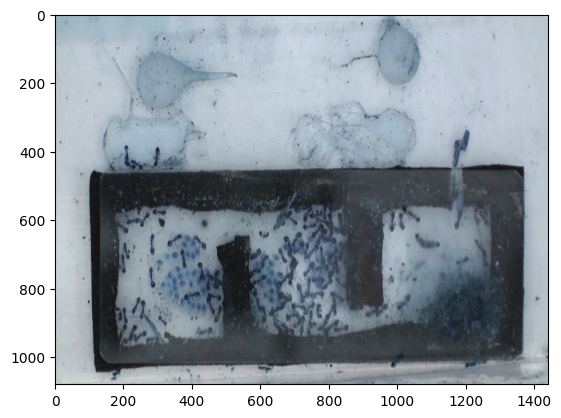

In [3]:
plt.imshow(data_marix[0], cmap='gray')

In [4]:

from scipy.signal import convolve2d

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


In [17]:
data_marix.shape

(1470, 1080, 1440, 3)

In [18]:
data_marix_gray=np.mean(data_marix,axis=3)

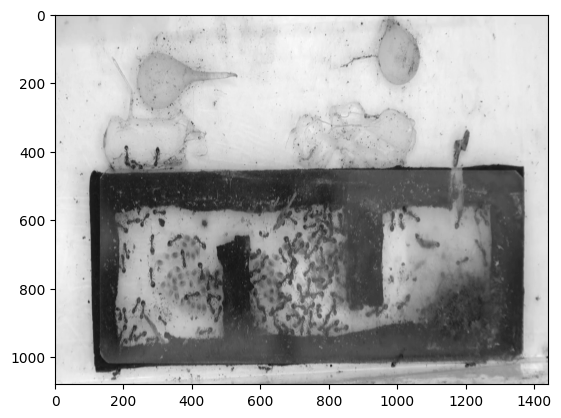

In [19]:
plt.imshow(data_marix_gray[0], cmap='gray')

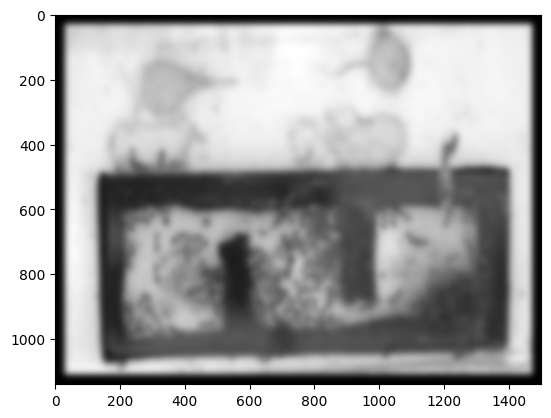

In [21]:
smooth_fourmis = convolve2d(data_marix_gray[0], gaussianKernel(10))
plt.imshow(smooth_fourmis, cmap='gray')

In [36]:
data_marix_gray[0][:200,:200]

array([[172.66666667, 172.66666667, 172.66666667, ..., 180.33333333,
        180.33333333, 180.33333333],
       [172.66666667, 172.66666667, 172.66666667, ..., 180.33333333,
        180.33333333, 180.33333333],
       [172.66666667, 172.66666667, 172.66666667, ..., 180.33333333,
        180.33333333, 180.33333333],
       ...,
       [196.66666667, 196.66666667, 195.66666667, ..., 190.        ,
        190.        , 186.        ],
       [197.66666667, 197.66666667, 196.66666667, ..., 191.        ,
        187.        , 188.        ],
       [197.66666667, 197.66666667, 196.66666667, ..., 191.        ,
        187.        , 188.        ]])

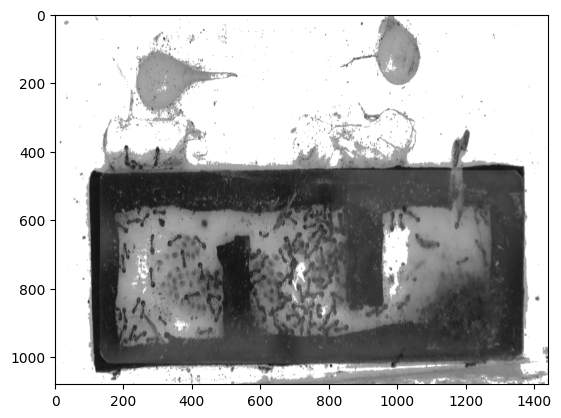

In [42]:
test=np.where((data_marix_gray[0]<170),data_marix_gray[0],255)
plt.imshow(test, cmap='gray')

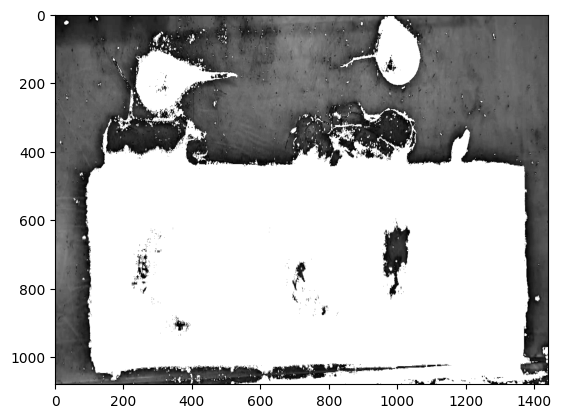

In [41]:
test_1=np.where(test>150,test,255)
plt.imshow(test, cmap='gray')

In [35]:
data_marix_gray[0][200:400,150:200]

array([[203.66666667, 202.        , 202.        , ..., 191.        ,
        187.        , 190.        ],
       [205.        , 201.        , 202.        , ..., 191.        ,
        187.        , 190.        ],
       [202.        , 202.        , 203.66666667, ..., 190.        ,
        191.        , 188.        ],
       ...,
       [171.        , 169.66666667, 171.        , ..., 170.66666667,
        170.33333333, 170.33333333],
       [172.33333333, 172.33333333, 171.        , ..., 171.33333333,
        169.33333333, 170.33333333],
       [173.66666667, 172.33333333, 171.        , ..., 171.33333333,
        169.33333333, 170.33333333]])

In [29]:
data_marix_gray[0][150,1000]

161.66666666666666

In [27]:
gaussianKernel(10)

array([[1.97311023e-07, 2.65013636e-07, 3.52405070e-07, ...,
        3.52405070e-07, 2.65013636e-07, 1.97311023e-07],
       [2.65013636e-07, 3.55946800e-07, 4.73324539e-07, ...,
        4.73324539e-07, 3.55946800e-07, 2.65013636e-07],
       [3.52405070e-07, 4.73324539e-07, 6.29408999e-07, ...,
        6.29408999e-07, 4.73324539e-07, 3.52405070e-07],
       ...,
       [3.52405070e-07, 4.73324539e-07, 6.29408999e-07, ...,
        6.29408999e-07, 4.73324539e-07, 3.52405070e-07],
       [2.65013636e-07, 3.55946800e-07, 4.73324539e-07, ...,
        4.73324539e-07, 3.55946800e-07, 2.65013636e-07],
       [1.97311023e-07, 2.65013636e-07, 3.52405070e-07, ...,
        3.52405070e-07, 2.65013636e-07, 1.97311023e-07]])

In [25]:
smooth_fourmis

array([[3.40690367e-05, 7.98280578e-05, 1.40676667e-04, ...,
        1.60230180e-04, 9.09238497e-05, 3.88045012e-05],
       [7.98280578e-05, 1.87047227e-04, 3.29623206e-04, ...,
        3.75439559e-04, 2.13046069e-04, 9.09238497e-05],
       [1.40676667e-04, 3.29623206e-04, 5.80877139e-04, ...,
        6.61616818e-04, 3.75439559e-04, 1.60230180e-04],
       ...,
       [1.72302634e-04, 4.04187237e-04, 7.11916882e-04, ...,
        6.04294394e-04, 3.43060795e-04, 1.46411564e-04],
       [9.77516787e-05, 2.29044535e-04, 4.02819046e-04, ...,
        3.40440956e-04, 1.93185842e-04, 8.24478976e-05],
       [4.20272479e-05, 9.84751524e-05, 1.73274351e-04, ...,
        1.45293468e-04, 8.24478976e-05, 3.51871325e-05]])